In [1]:
import os
import sys

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Flatten, Dense, Reshape, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

# modify sys.path for it to contain the main repo path so we can import modules such as below
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from utils.helper import get_root_dir, set_seed, setup_gpu
from utils.data import load_data
from utils.plots import plot_reconstructions, plot_history
from utils.latent_space import plot_latent_space
from utils.evaluation import evaluate_autoencoder
from utils.loss import ssim_loss, ssim_l1_loss, dssim_loss

In [2]:
# Hyperparameter to tune
config = {
    "comment" : "regularised autoencoder",
    "epochs" : 2,
    "loss" : 'ssim_loss', # loss needs to be changes in creation of autoencoder functions from config are not callable
    "optimizer" : "adam",
    "dropout_value" : 0.3,
    "batch_norm": True,
    "batch_size" : 32,
    "filter": 32,
    "latent_dim" : 512,
    "threshold_percentage" : 95,
    "data_class" : "screw",
    "model_type" : "autoencoder"
}

# Rather static parameters, no need to track
IMAGE_SIZE = (256, 256)
INPUT_SHAPE = IMAGE_SIZE + (3,)

In [3]:
wandb.init(project="itu-aml-project", config=config)
config = wandb.config # this turns our hyperparameter config into a proper object with attributes

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jonathantiedchen (itu-aml-project). Use `wandb login --relogin` to force relogin


In [4]:
root_dir = get_root_dir()
setup_gpu()
set_seed(1234)

model_dir = os.path.join(root_dir, 'models', config.model_type)

cpkt_path = os.path.join(model_dir, 'logs', 'checkpoints', f'{config.comment}_checkpoint.model.keras')
weights_path = os.path.join(model_dir, 'logs', 'weights', f'{config.comment}_model.keras')
assert not os.path.exists(weights_path), f'Path already exists: {weights_path}. Please change the comment.'

No GPU found, using CPU.


In [5]:
train_generator, validation_generator, test_generator = load_data(category=config.data_class, batch_size=config.batch_size)

Found 256 images belonging to 1 classes.
Found 64 images belonging to 1 classes.
Found 160 images belonging to 6 classes.


In [8]:
def regularized_autoencoder(input_shape=(256, 256, 3), optimizer='adam', latent_dim=512, loss = 'mse', dropout_value=0.5):
    """
    input_shape (tuple): Shape of the input images (height, width, channels).
    latent_dim (int): Dimension of the latent space.
    dropout (bool): activate dropout layer
    dropout_value (float): define own dropout value
    loss (str): define loss used to train autoencoder. Has to be 'mse','msa',ssim_loss,ssim_l1_loss
    """
    
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(32, (3, 3), padding='same')(input_img)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(dropout_value)(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(dropout_value)(x)


    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(dropout_value)(x)


    # Flatten and Bottleneck
    x = Flatten()(x)
    encoded = Dense(latent_dim, activation='relu')(x)

    # Decoder
    x = Dense(32 * 32 * 128, activation='relu')(encoded)
    x = Reshape((32, 32, 128))(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    # Output layer
    decoded = Conv2D(input_shape[2], (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return autoencoder

# get correct loss from config as functions are not callable from config itself
if config.loss == 'mae': loss = 'mae'
elif config.loss == 'mse': loss = 'mae'
elif config.loss == 'dssim_loss': loss = dssim_loss
elif config.loss == 'ssim_loss': loss = ssim_loss
elif config.loss == 'ssim_l1_loss': loss = ssim_l1_loss
else:
    raise ValueError(f"Unknown loss function: {config.loss}. Please define a function to calculate the error.")

autoencoder = regularized_autoencoder(
    input_shape=INPUT_SHAPE, 
    optimizer=config.optimizer, 
    latent_dim=config.latent_dim, 
    loss=ssim_loss,
    dropout_value = 0.3
)

print("Input shape:", autoencoder.input_shape)
print("Output shape:", autoencoder.output_shape)

autoencoder.summary()

/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/AML/AML_Project/itu-aml-anomaly-detection/.venv/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Input shape: (None, 256, 256, 3)
Output shape: (None, 256, 256, 3)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 65536)          │    33,619,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 256, 256, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,951,491 (259.21 MB)

 Trainable params: 67,951,491 (259.21 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
#define early stopping and checkpoints
early_stop = EarlyStopping(
    monitor="val_loss", 
    mode="min",
    patience=20, 
    start_from_epoch=20
    )

checkpoint = ModelCheckpoint(
    cpkt_path, 
    monitor="val_loss", 
    mode="min", 
    save_best_only=True, 
    verbose=1
    )

history = autoencoder.fit(
    train_generator,
    epochs=config.epochs,
    validation_data=validation_generator,
    callbacks=[
        early_stop,
        checkpoint,
        WandbMetricsLogger(),
        # WandbModelCheckpoint("models"), # Saves model checkpoint to W&B
    ],
)

wandb.finish()

Epoch 1/2
3/8 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.4718 - loss: 0.2526

KeyboardInterrupt: 

In [26]:
from utils.loss import ssim_loss
print(ssim_loss)

<function ssim_loss at 0x302b6c790>


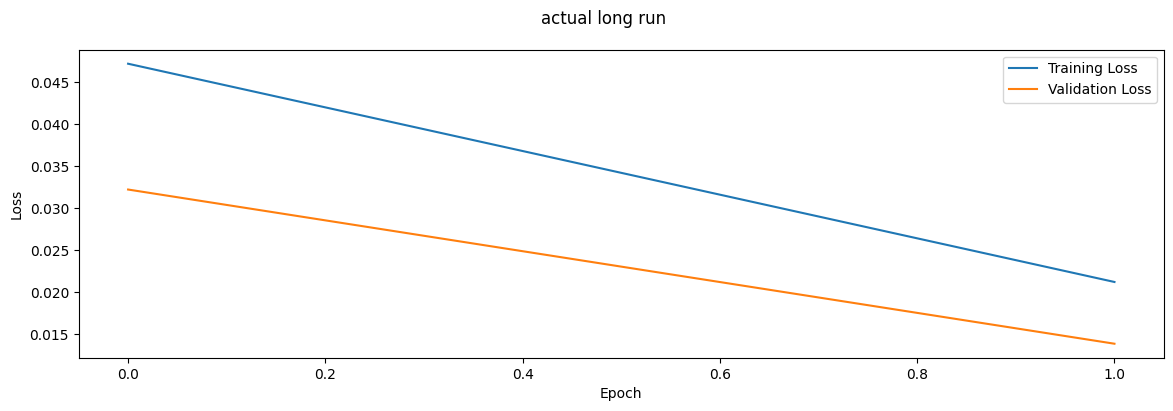

Best train_loss: 0.0212
Best val_loss: 0.0139
Last improvement of val_loss at epoch: 1


In [23]:
# plot the training history
plot_history(comment=config.comment, history=history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


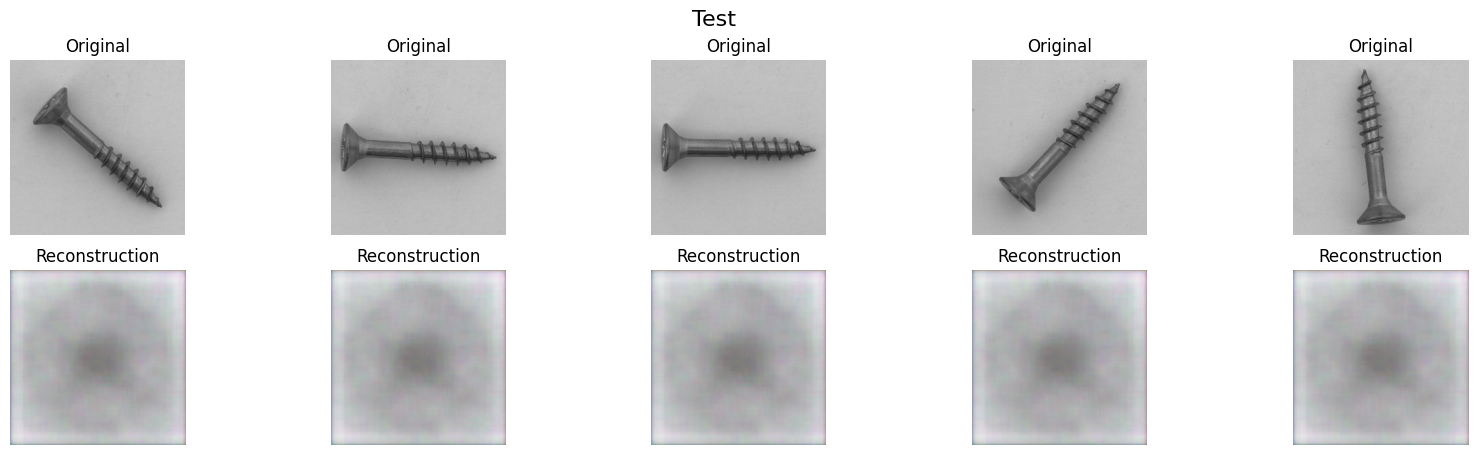

In [25]:
plot_reconstructions(autoencoder, test_generator, n_images=5, title='Test')


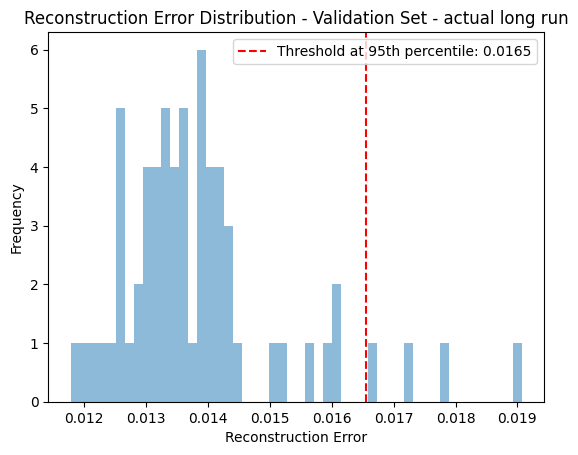

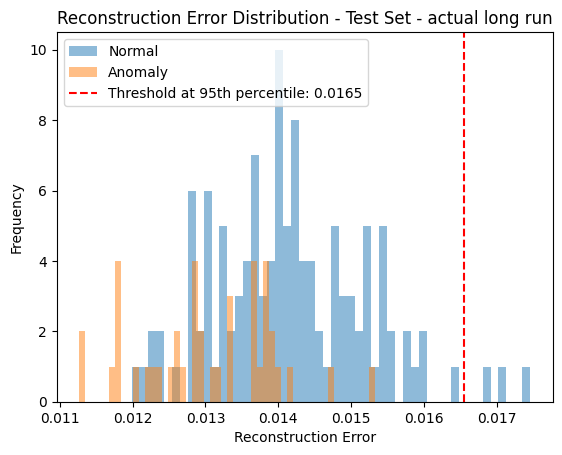

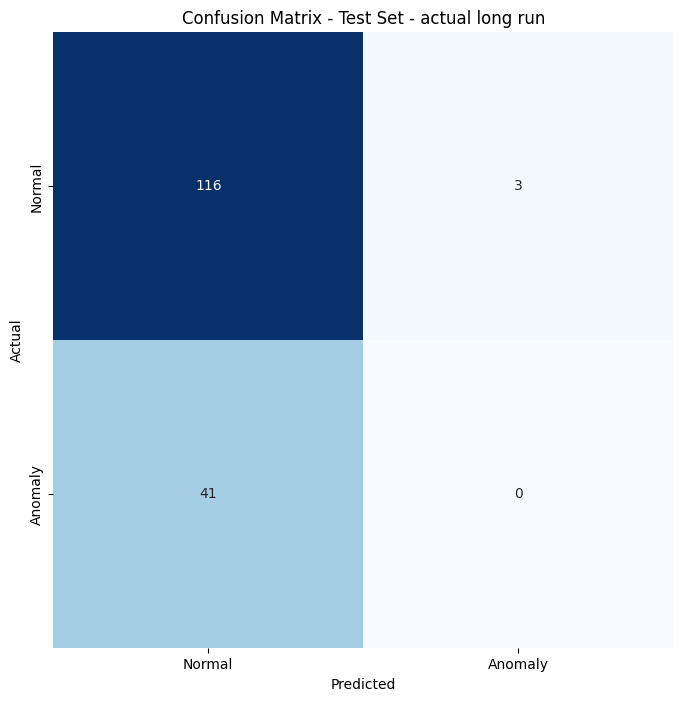

In [26]:
evaluate_autoencoder(
    config = config,
    autoencoder=autoencoder,
    validation_generator=validation_generator,
    test_generator=test_generator
    )

/var/folders/cw/nsgz30_17pq84g4s1jh0lgtw0000gp/T/ipykernel_64683/2744363305.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', num_classes)


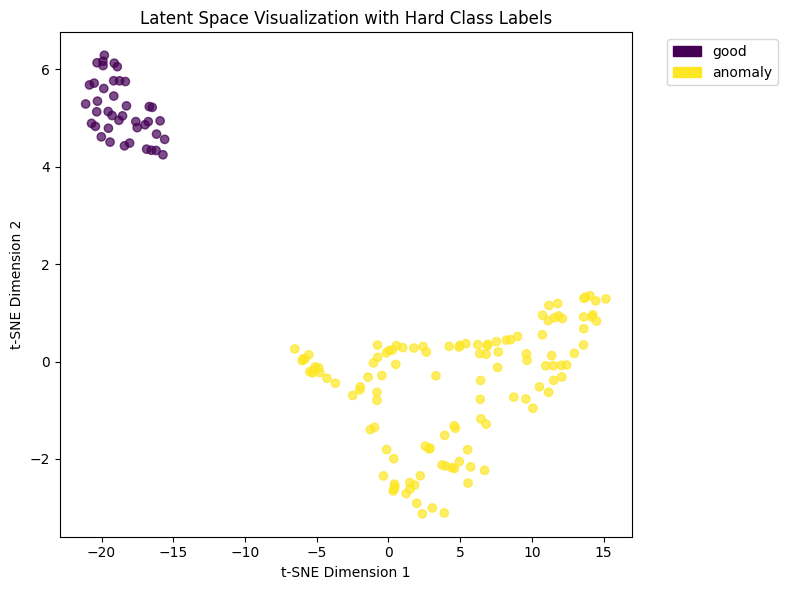

In [39]:
plot_latent_space(autoencoder, test_generator, layer_name='dense_2')